# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 


### Import lesson's functions

In [14]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False).ravel())
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=False).ravel()
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

img = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, raw_heat_map=False, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    imcopy2 = np.copy(img)
    
    global heat

    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy2, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn

    if raw_heat_map is True:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # remove some heat from whole heat map
    heat[heat > 0] *= 0.65
    #heat[heat > 0] -= 1
    #heat[heat > 10] = 2

    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    if raw_heat_map is False:
        heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    imcopy = draw_labeled_bboxes(imcopy, labels)    
         
    return imcopy, imcopy2, heatmap


Number of car images:     8792
Number of non-car images: 8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
15.01 Seconds to train SVC...
Test Accuracy of SVC =  0.9829


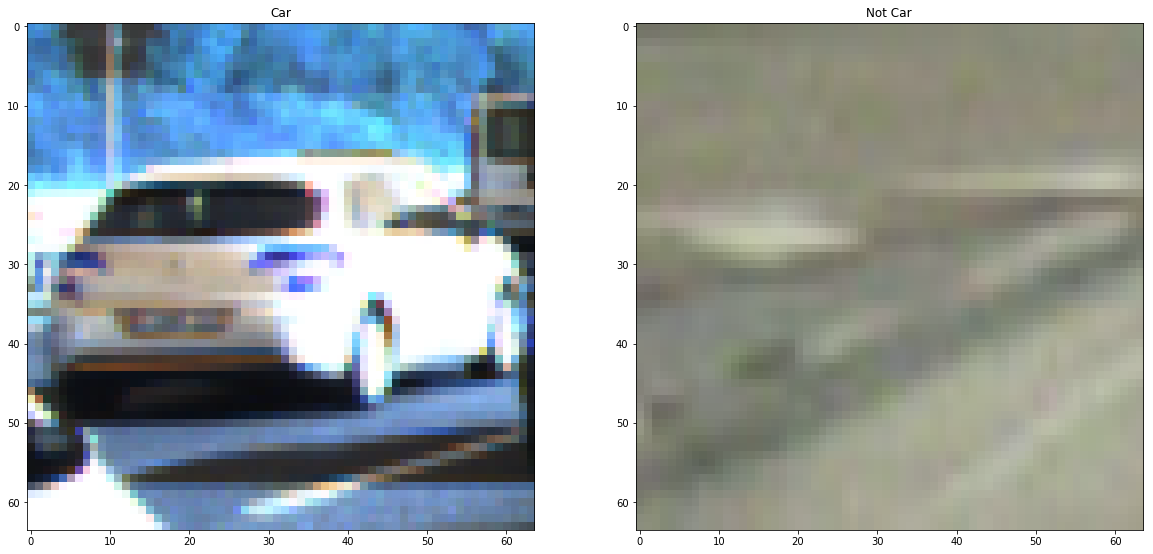

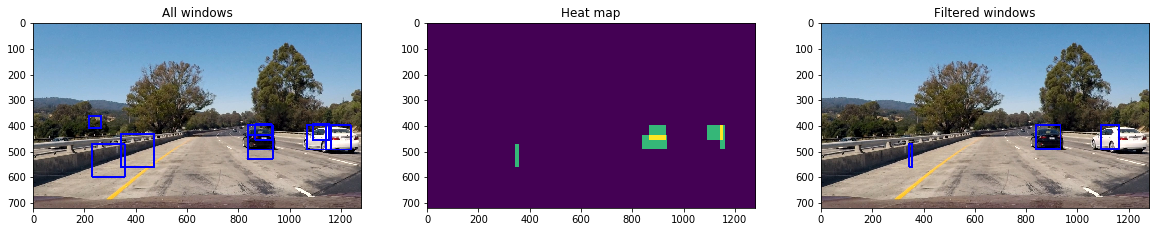

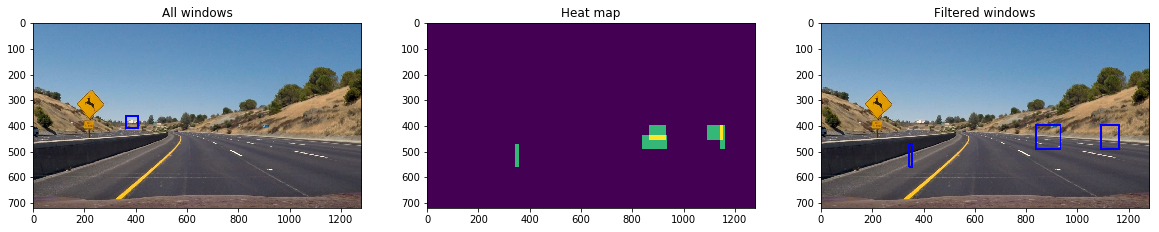

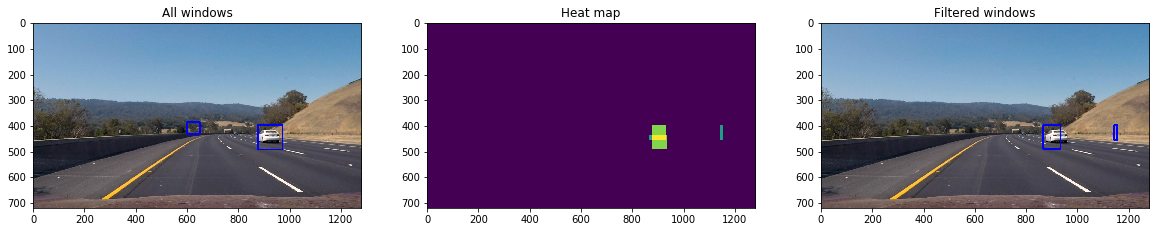

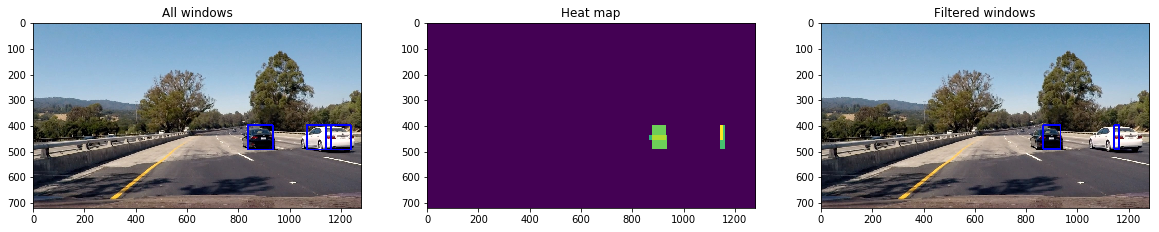

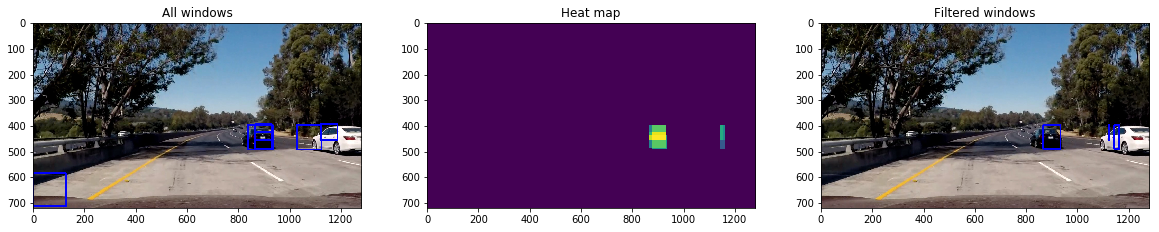

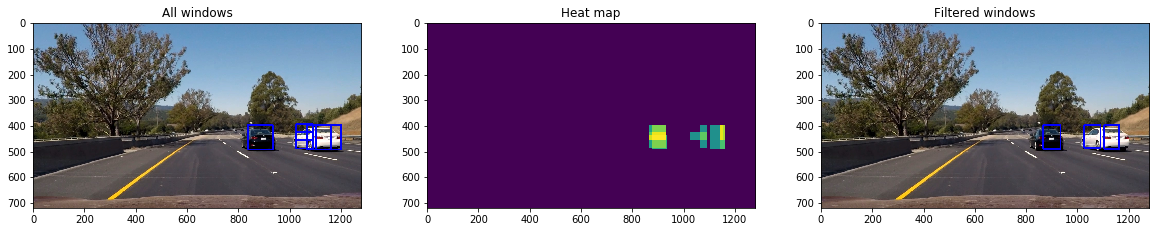

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from random import shuffle
from sklearn.model_selection import train_test_split
%matplotlib inline


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
def detect_car_and_draw_bounding_box(image, draw_image, norm_scaler, raw_heat_map=True, show_image=True):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    windows = []

    windows.extend(slide_window(image, x_start_stop=[None, None], 
                    y_start_stop=[int(image_shape[0]*0.5), int(image_shape[0]*0.60)], 
                    xy_window=(48, 48), xy_overlap=(0.5, 0.5)))

    windows.extend(slide_window(image, x_start_stop=[None, None], 
                    y_start_stop=[int(image_shape[0]*0.5), int(image_shape[0]*0.8)], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)))

    windows.extend(slide_window(image, x_start_stop=[None, None], 
                    y_start_stop=[int(image_shape[0]*0.55), int(image_shape[0]*0.9)], 
                    xy_window=(96, 96), xy_overlap=(0.6, 0.6)))

    windows.extend(slide_window(image, x_start_stop=[None, None], 
                    y_start_stop=[int(image_shape[0]*0.6), int(image_shape[0]*1.0)], 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7)))

#     windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(, 128), xy_overlap=(0.5, 0.5)))

    hot_windows = search_windows(image, windows, svc, norm_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img, window_img2, car_heat_map = draw_boxes(draw_image, hot_windows, raw_heat_map=raw_heat_map, color=(0, 0, 255), thick=6)   
    if show_image:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('All windows')
        ax1.imshow(window_img2)
        ax2.set_title('Heat map')
        ax2.imshow(car_heat_map)
        ax3.set_title('Filtered windows')
        ax3.imshow(window_img)
        f.savefig('./output_images/' + ('raw_' if raw_heat_map is True else '') + 'plot' + str(index) + '.jpg', bbox_inches='tight', pad_inches=0)
        
#         plt.figure()
#         plt.imshow(window_img)
#         plt.figure()
#         plt.imshow(car_heat_map)
        
#         cmap = plt.cm.jet
#         norm = plt.Normalize(vmin=window_img.min(), vmax=window_img.max())
#         print(window_img.min(),window_img.max())
        # map the normalized data to colors
        # image is now RGBA (512x512x4) 
        #window_img = cmap(norm(window_img))
        #print(norm(window_img).astype(np.float).shape)
        #print(window_img.shape)
        #window_img[window_img > 255] = 255
        #plt.imshow(window_img)
        #print(window_img.shape)
        
        #cv2.imwrite('./output_images/test' + str(index) + '.jpg', cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))
        #cv2.imwrite('./output_images/test' + str(index) + '.jpg', window_img)
        #cv2.imwrite('./output_images/test' + str(index) + '.jpg', cv2.cvtColor(window_img.astype(np.float), cv2.COLOR_RGBA2RGB))

    return window_img
    #return np.dstack((window_img, window_img, window_img)) #cv2.cvtColor(window_img,cv2.COLOR_GRAY2RGB) #norm(window_img)


# Read in cars and notcars
#images = glob.glob('*.jpeg')
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

print('Number of car images:     ' + str(len(cars)))
print('Number of non-car images: ' + str(len(notcars)))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
shuffle(cars)
shuffle(notcars)
sample_size = min(len(cars), len(notcars))
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

car_img = cv2.imread(cars[211])
notcar_img = cv2.imread(notcars[211])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Car')
ax1.imshow(car_img)
ax2.set_title('Not Car')
ax2.imshow(notcar_img)
f.savefig('./output_images/car_and_not_car_lot.jpg', bbox_inches='tight', pad_inches=0)

image_shape = mpimg.imread('test_images/test1.jpg').shape

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb'#'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' #0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [int(image_shape[0]/2), image_shape[0]*0.9] # Min and max in y to search in slide_window()

if False:  # HOG experimentation
    feature_image = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
    car_hog_feat, hog_vis = get_hog_features(feature_image[:,:,0], orient, 
                pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.set_title('Car')
    ax1.imshow(feature_image)
    ax2.set_title('Not Car')
    ax2.imshow(hog_vis)

    feature_image = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2YCrCb)
    notcar_hog_feat, hog_vis = get_hog_features(feature_image[:,:,0], orient, 
                pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax3.set_title('Not Car')
    ax3.imshow(feature_image)
    ax4.set_title('Car')
    ax4.imshow(hog_vis)
    f.savefig('./output_images/HOG_example.jpg', bbox_inches='tight', pad_inches=0)

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)  #
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

for index in range(1,7):
    test_image = mpimg.imread('test_images/test' + str(index) + '.jpg')
    test_image_for_drawing = np.copy(test_image)
    detect_car_and_draw_bounding_box(test_image, test_image_for_drawing, X_scaler, raw_heat_map=False)


## Test on Videos


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
mtx = None
dist = None

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global X_scaler
    draw_image = np.copy(image)
    final_image = detect_car_and_draw_bounding_box(image, draw_image, X_scaler, raw_heat_map=False, show_image=False)
    
    return final_image

In [18]:
video_output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [44:47<00:02,  2.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 44min 30s, sys: 14.7 s, total: 44min 45s
Wall time: 44min 47s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup Template

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


[//]: # (Image References)
[image0]: ./output_images/car_and_not_car_lot.jpg
[image0b]: ./output_images/HOG_example.jpg
[image0c]: ./output_images/windows.jpg
[image1a]: ./output_images/raw_plot1.jpg
[image2a]: ./output_images/raw_plot2.jpg
[image3a]: ./output_images/raw_plot3.jpg
[image4a]: ./output_images/raw_plot4.jpg
[image5a]: ./output_images/raw_plot5.jpg
[image6a]: ./output_images/raw_plot6.jpg
[image1b]: ./output_images/plot1.jpg
[image2b]: ./output_images/plot2.jpg
[image3b]: ./output_images/plot3.jpg
[image4b]: ./output_images/plot4.jpg
[image5b]: ./output_images/plot5.jpg
[image6b]: ./output_images/plot6.jpg
[video1]: ./project_video.mp4


## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
## Writeup / README

### 1. Writeup / README that includes all the rubric points and how you addressed each one.  

You're reading it!

## Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the 1st code cell of the IPython notebook.

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image0]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image0b]

### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters. First I experimented with the different color spaces (RGB, HSV, LUV, HLS, YUV, YCrCb) and found that YCrCb gave me the best results. Next I tried to determine which (or all) of the features gave me the best result and it turned out that the combination of all of them was the best - get features for the different channels and concatenate them together. 

For HOG orientations, I wanted to capture gradients better so I tried to go down to 20 degree bins (18 bins out of 360 degrees). This increased the number of features but also resulted in a lot more false positives. In the end I used 9 orientations. Similarly I experimented with number of pixels in the cell (16x16) but that again created too many false positives.  Final pixels_per_cell was 8x8.

The upside of using only 9 orientations (40 degrees) was that the feature vector stayed relatively small and therefore was faster to train.


### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The code for this step is contained in the 2nd code cell of the IPython notebook.  My choice of classifier was a linear SVM. But before I trained the classifier I first randomized the samples. Used a training and test split of 80-20. Before I fed the features to the classifier, I normalized the feature vector. I used the same scaler for both training and inference time. 

## Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

The code for this step is contained in the 1st and 2nd code cell of the IPython notebook. The utility function `slide_window` is in the 1st cell and finds out the extents of all the windows given windowing parameters. The `slide_window` function is called by `detect_car_and_draw_bounding_box` (2nd code cell). This is where I created windows of different sizes. 

I ignored the top half of hte image as that is above the horizon. For the 2nd half of the image, I used small windows on the pixels closer to the horizon and larger windows for pixels closer to the bottom of the image.  This way cars closers up are detected by the bigger windows while the smaller cars at the distance are detected by small ones.

Another important factor here is the overlap ratio. For windows closer up, the same overlap ratio of 0.5 would have resulted in a gap between two detectios e.g. for a 128x128 window, that gap would be 64 pixels. That was too big of a hole where I was not getting detections and so I increased the overlap ratio for larger windows.

### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

In the end I used the YCrCb 3-channel HOG features as they provided the best results. Here are some example images:

![alt text][image0c]
---

## Video Implementation

### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./output_video.mp4)


### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

The code for this step is contained in the 1st and 1st code cell of the IPython notebook. The `draw_boxes` function implements a running heatmap. Every detected car window adds heat to the heatmap. Overlapping window regions therefore get higher probability of car presence. There is thresholding implemneted as well which removes one-off false positives.

If only heat map accumulation is done, then moving cars will leave a trail of heat behind them which will stay. In order to avoid this, we need to add a 'cooling' step to the heat map.  This is done by the following code:

```python
    # remove some heat from whole heat map
    heat[heat > 0] *= 0.65
```

Once I have a heatmap that represents the running position of the cars, I used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

## Here are six frames and their corresponding raw heatmaps:

![alt text][image1a]
![alt text][image2a]
![alt text][image3a]
![alt text][image4a]
![alt text][image5a]
![alt text][image6a]

## Here are the same six frames and their corresponding integrated heatmap:

Note that the randomization seed was kept the same to allow for comparison of results. The images below have a running heat map with cooling and thresholding.

![alt text][image1b]
![alt text][image2b]
![alt text][image3b]
![alt text][image4b]
![alt text][image5b]
![alt text][image6b]


---

## Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Issues:
- Biggest issue overall was trainig time. My implementation is not the most efficient as I have focussed more on filteration of results.

Where pipeline will likely fail:
- If the vehicles always gets detected by a single window, then it will be filtered out as a false positive. For the project video it doesn't happen as much but in another scanario it might. This is compensated by having windows of multiple sizes in the search, which gives us multiple windows per car.  

How to make the solution more robust:
- I would make the solution better by using HOG feature more intelligently for test images.
- Another way of making the solution more robust is to filter out near duplicates from training data. Because some of the images are from a series of frames in a video, some of them might end up in training while their (very similar) neighbors would end up in the testing. This almost breaks the whole notion of never testing of data that you have already seen.
